# Context windows

In [1]:
%matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from kooplearn.data import TrajectoryContextDataset, TensorContextDataset

# Import dependencies
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs

In [3]:
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks

## Context windows from tropical cyclones

We first investigate the kooplearn context window data structure and build some tools to translate CLIMADA's TCTracks data into context windows.

For now we just load some cyclone tracks from the East Pacific ("EP") in the years 2000 and 2001.

In [4]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='EP', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-07-04 21:11:39,462 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-04 21:11:40,203 - climada.hazard.tc_tracks - WARNING - 8 storm events are discarded because no valid wind/pressure values have been found: 2000138N16119, 2000187N12245, 2000201N11224, 2000203N17249, 2000209N06182, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 36


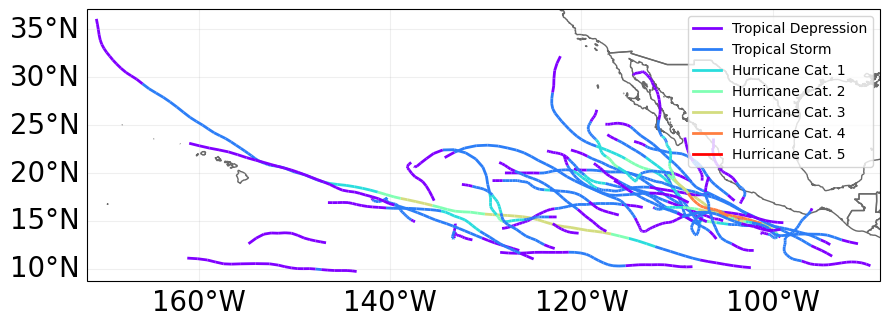

In [5]:
ax = tc_tracks.plot()

In [6]:
feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]

In [7]:
data_array_list = data_array_list_from_TCTracks(tc_tracks=tc_tracks, feature_list=feature_list)

In [8]:
context_length = 12

In [9]:
tensor_context_dataset = context_dataset_from_TCTracks(
    tc_tracks, feature_list=feature_list, context_length=context_length
)

C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\164162217.py:1: UserWarning: Data entry 32 has been removed since it is shorter than the 
                context_length.
  tensor_context_dataset = context_dataset_from_TCTracks(


In [10]:
tensor_context_dataset.shape

(1068, 12, 4)

In [11]:
tensor_context_dataset[0]

TensorContextDataset <item_count=1, context_length=12, data=[[[  13.30000019  -99.19999695   25.         1005.        ]
  [  13.62234306  -99.72260284   27.         1004.        ]
  [  13.89999962 -100.19999695   30.         1004.        ]
  [  14.12994671 -100.67256927   30.         1003.        ]
  [  14.30000019 -101.09999847   30.         1003.        ]
  [  14.42987347 -101.465065     32.         1002.        ]
  [  14.5        -101.80000305   35.         1002.        ]
  [  14.51498032 -102.15757751   37.         1001.        ]
  [  14.5        -102.5          40.         1001.        ]
  [  14.49243164 -102.80753326   42.         1000.        ]
  [  14.5        -103.09999847   45.         1000.        ]
  [  14.54996109 -103.39995575   47.          998.        ]]]>

In [12]:
tensor_context_dataset[0].lookback(3), tensor_context_dataset[0].lookforward(3)

(array([[[  13.30000019,  -99.19999695,   25.        , 1005.        ],
         [  13.62234306,  -99.72260284,   27.        , 1004.        ],
         [  13.89999962, -100.19999695,   30.        , 1004.        ]]]),
 array([[[  14.12994671, -100.67256927,   30.        , 1003.        ],
         [  14.30000019, -101.09999847,   30.        , 1003.        ],
         [  14.42987347, -101.465065  ,   32.        , 1002.        ],
         [  14.5       , -101.80000305,   35.        , 1002.        ],
         [  14.51498032, -102.15757751,   37.        , 1001.        ],
         [  14.5       , -102.5       ,   40.        , 1001.        ],
         [  14.49243164, -102.80753326,   42.        , 1000.        ],
         [  14.5       , -103.09999847,   45.        , 1000.        ],
         [  14.54996109, -103.39995575,   47.        ,  998.        ]]]))

Everything seems to work.

## Kooplearn TCTracks

Next we feed the obtained context windows into the Koopman operator learning pipeline.

In [13]:
import ml_confs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks

Load data

In [14]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='EP', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2024-07-04 21:11:57,011 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-04 21:11:58,161 - climada.hazard.tc_tracks - WARNING - 8 storm events are discarded because no valid wind/pressure values have been found: 2000138N16119, 2000187N12245, 2000201N11224, 2000203N17249, 2000209N06182, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 36


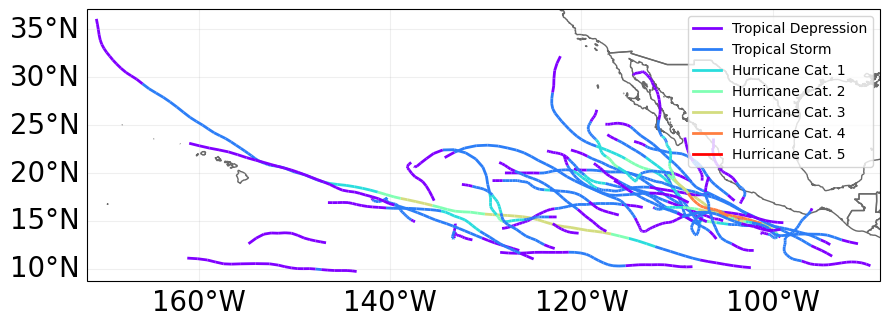

In [15]:
ax = tc_tracks.plot()

Train test split

In [16]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 12
feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\433391415.py:5: UserWarning: Data entry 3 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(


In [17]:
tensor_context_train.shape, tensor_context_test.shape

((883, 12, 4), (185, 12, 4))

In [18]:
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [19]:
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (883, 12, 4): 883 contexts of length 12 with 4 features each
Test contexts have shape (185, 12, 4): 185 contexts of length 12 with 4 features each


### Determine characteristic length scale of the dataset used in the kernel-baded Koopman models

We obtain a characteristic length scale of the dataset by getting the $q$-quantile of the pairwise distances for each track, and averaging over tracks.

Alternative options would be:

(1) To consider the pairwise distances of the full dataset, i.e. taken over all tracks.

(2) To only take pairwise distances of the $k$-subsequent data points, which might be a bit more natural to the path geometry of the tracks.

Note: We can assume some locality condition, i.e. the movement of the tropical cyclone at time point $i$ and position $(lon, lat)$ is only influenced by the states of the cyclone at a few, locally close, previous time steps. Under this assumtion, a length scale that only captures the distances between data point in the vicinity of the target point would be probably more adequat than the global pairwise distances over the entire track.

In [20]:
#TODO We keep this for future investigation and consider in the following the global length scale of one track.

First we visualise the pairwise distances of an example track

Data array shape: (27, 4)
Pairwise distance array shape: (351,)


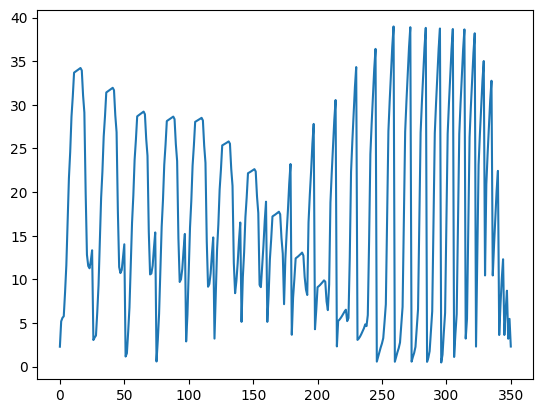

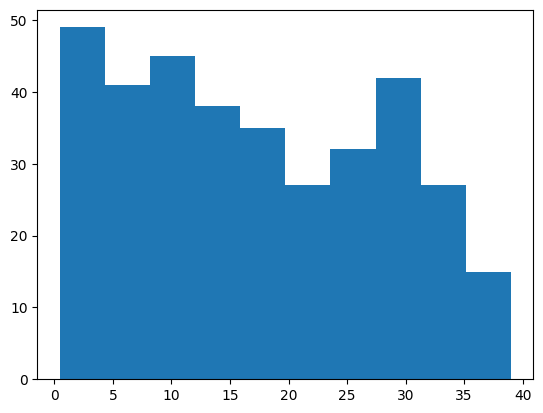

In [21]:
data_array_list = data_array_list_from_TCTracks(tc_tracks_train, feature_list)
data_array = data_array_list[11]
print("Data array shape:", data_array.shape)
data_array_pdist = pdist(data_array)
print("Pairwise distance array shape:", data_array_pdist.shape)
plt.plot(range(len(data_array_pdist)), data_array_pdist)
plt.show()

plt.hist(data_array_pdist)
plt.show()

Then we compute the characteristic length scale from the training track data.

In [22]:
mean_quantile = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
mean_quantile

7.168544346832558

### Train the models

In [23]:
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF

In [24]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='EP', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2024-07-04 21:12:15,891 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-07-04 21:12:17,090 - climada.hazard.tc_tracks - WARNING - 10 storm events are discarded because no valid wind/pressure values have been found: 2000138N16119, 2000187N12245, 2000201N11224, 2000203N17249, 2000209N06182, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 443


In [25]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 12
feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\4106258163.py:5: UserWarning: Data entry 23 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\4106258163.py:5: UserWarning: Data entry 27 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\4106258163.py:5: UserWarning: Data entry 104 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\4106258163.py:5: UserWarning: Data entry 109 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_18748\4106258163.py:5: UserWarning: Data en

In [26]:
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (17727, 12, 4): 17727 contexts of length 12 with 4 features each
Test contexts have shape (1794, 12, 4): 1794 contexts of length 12 with 4 features each


Define a standard kernel example

In [27]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 8.299495720153939


Wrapper function for measuring timings

In [28]:
# Wrapper function useful for measuring the execution time of functions
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
from time import perf_counter

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

In [29]:
contexts['train'].shape

(17727, 12, 4)

In [30]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        model, fit_time = timer(model.fit)(contexts['train'][:stop])
        # One-step prediction
        X_pred_test = model.predict(contexts['train'])
        X_true_test = contexts['train'].lookforward(model.lookback_len)

        results[name] = {
            'fit_time': fit_time,
            'RMSE_onestep_test': np.sqrt(np.mean((X_pred_test - X_true_test)**2)),
        }
        print(r'Fitting of {} model took {:.2f}s and has a test RMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['RMSE_onestep_test']))
    return results

We define some training dataset sizes for testing.

In [31]:
train_stops = np.logspace(2.5, 3.5, 5).astype(int)
train_stops

array([ 316,  562, 1000, 1778, 3162])

In [32]:
results = []
for stop in train_stops:
    models = {
        'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
        'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
        'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))


Training points: 316
Fitting of RRR model took 2.19s and has a test RMSE of 484.61626.
Fitting of Randomized-RRR model took 0.37s and has a test RMSE of 487.95699.
Fitting of Nystroem-RRR model took 3.69s and has a test RMSE of 485.91197.

Training points: 562
Fitting of RRR model took 2.75s and has a test RMSE of 477.08652.
Fitting of Randomized-RRR model took 0.61s and has a test RMSE of 486.44986.
Fitting of Nystroem-RRR model took 3.21s and has a test RMSE of 482.16459.

Training points: 1000
Fitting of RRR model took 2.10s and has a test RMSE of 464.92265.
Fitting of Randomized-RRR model took 0.97s and has a test RMSE of 478.81556.
Fitting of Nystroem-RRR model took 3.61s and has a test RMSE of 472.66582.

Training points: 1778
Fitting of RRR model took 3.62s and has a test RMSE of 458.67974.
Fitting of Randomized-RRR model took 0.35s and has a test RMSE of 473.41823.
Fitting of Nystroem-RRR model took 0.66s and has a test RMSE of 465.13269.

Training points: 3162
Fitting of RRR 

In [33]:
timings = {name: np.array([res[name]['fit_time'] for res in results]) for name in models.keys()}
test_rMSE = {name: np.array([res[name]['RMSE_onestep_test'] for res in results]) for name in models.keys()}

speedup = {}
for name in models.keys():  
    speedup[name] = timings['RRR']/timings[name]

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 5.54x
Average fitting time speed-up for Nystroem-RRR: 5.80x


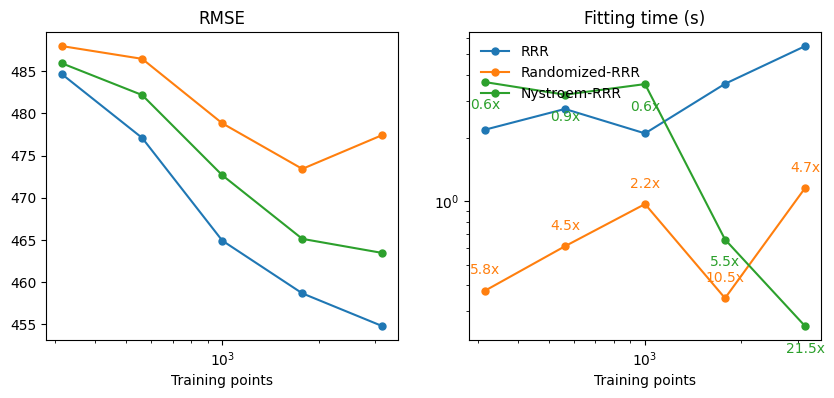

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup[name]):.2f}x")



These results are not yet very impressive. However, one has to keep in mind that the input data was not standardised (as often done in a pre-processing step) to zero mean and unit variance. Hence the RMSE error of $\sim 470$ does not necessarily mean bad prediction performance, if compared to the spatial scales on which the tropical cylones evolve.

In the next notebook `koopman_kernel_for_TC.ipynb` we are going to investigate these questions in more depth.